<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
import os
import pandas as pd
import skimage.io
from skimage.transform import resize

all_data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

data = [transform(x) for x in all_data]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(data,
                                  test_size=0.33,
                                  random_state=42)

In [7]:
print("Train size:", len(X_train))
print("Val size:", len(X_val))

Train size: 8805
Val size: 4338


In [8]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(dataset=X_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=X_val, batch_size=batch_size, shuffle=True)

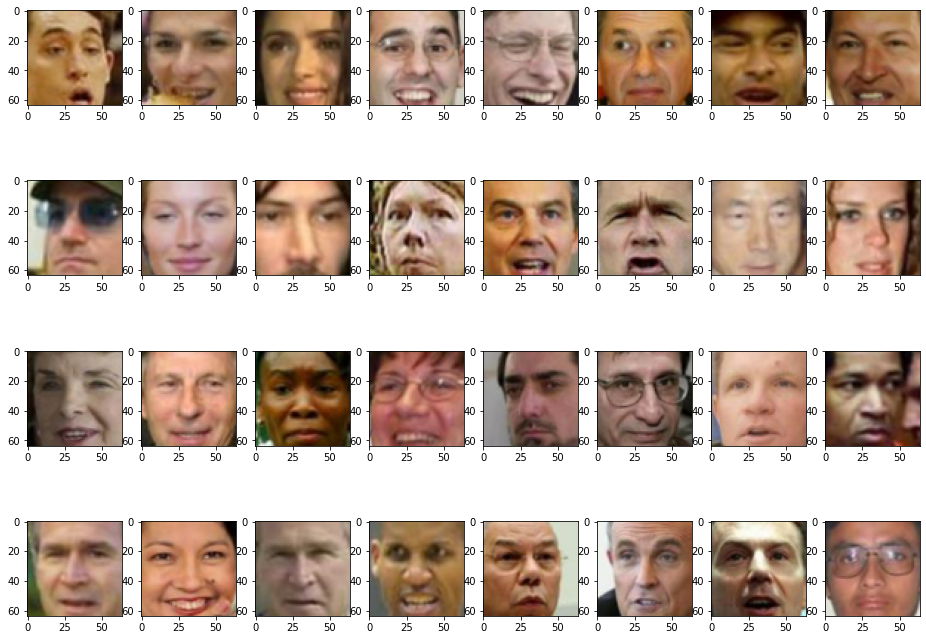

In [9]:
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]
data = next(iter(train_dataloader))
for ax, d in zip(axes.flatten(), data):
  imshow(d.data.cpu(), plt_ax=ax)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

# Задание 1

Постройте архитектуру автокодировщика. Поэксперементируйте с скрытым пространством и сделайте выводы по его размеру.

In [10]:
dim_code = # выберите размер латентного вектора

In [11]:
from torch.nn.modules.pooling import MaxUnpool2d
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
          
        )

        self.decoder = nn.Sequential(
          
        )
        
    def forward(self, x):
        return reconstruction, latent_code

In [12]:
criterion = # лосс
autoencoder = # ваша модель

optimizer = # любимый оптимизатор

In [ ]:
from torchsummary import summary

summary(autoencoder, (3, 64, 64), device="cpu")

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
autoencoder.to(device)

In [15]:
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

In [16]:
from time import time
from IPython.display import clear_output

def train_ae(model, opt, loss_fn, epochs, data_tr, data_val):
    history = {"train_loss": [],
               "val_loss": []}

    best_loss = float("inf")

    #X_val = next(iter(data_val))[:6]

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device).double()
            
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            reconstructed = model(X_batch.float())
            loss = loss_fn(reconstructed[0], X_batch.float())
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        history["train_loss"].append(avg_loss.cpu().detach().numpy())

        # show intermediate results
        model.eval()  # testing mode
        
        avg_val_loss = 0
        for X_val_batch in data_val:
          reconstructed_val_images = model(X_val_batch.to(device))[0].detach().cpu()
          avg_val_loss += loss_fn(reconstructed_val_images, X_val_batch).numpy() / len(data_val)
        
        history["val_loss"].append(avg_val_loss)
        
        if avg_val_loss < best_loss:
          best_loss = avg_val_loss
          torch.save(model.state_dict(), "model.pt")

        # Visualize tools
        plt.figure(figsize=(12, 8))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(inv_normalize(X_val_batch[k]).numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(np.rollaxis(inv_normalize(reconstructed_val_images[k]).numpy(), 0, 3))
            plt.title('Reconstruction')
            plt.axis('off')
        plt.suptitle('%d / %d - train_loss: %f, val_loss: %f' % (epoch+1, epochs, avg_loss, avg_val_loss))
        plt.show()
    # load best model
    model.load_state_dict(torch.load("model.pt"))
    return history

In [17]:
def plot_history(history, title):
  plt.figure(figsize=(12, 8))
  plt.plot(history["train_loss"], label="train loss", c="r")
  plt.plot(history["val_loss"], label="val loss", c="g")
  plt.legend()
  plt.title(title)

In [ ]:
history_ae = train_ae(autoencoder, optimizer, criterion, 20, train_dataloader, val_dataloader)

In [ ]:
plot_history(history_ae, "AE")

**Для проверяющих: модель с лучшим лоссом сохранена и уже загружена (это в коде трейна прописано).**

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def plot_reconstruction(model, val_dataloader):
  X_val = next(iter(val_dataloader))[:6]
  model.eval()
  reconstructed_val_images = model(X_val.to(device))[0].detach().cpu()

  plt.figure(figsize=(12, 8))
  for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(np.rollaxis(inv_normalize(X_val[k]).numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(np.rollaxis(inv_normalize(reconstructed_val_images[k]).numpy(), 0, 3))
    plt.title('Reconstruction')
    plt.axis('off')
  plt.show()

In [ ]:
plot_reconstruction(autoencoder, val_dataloader)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

Попробуем сгенерировать изображение из нормального распределения:)

In [ ]:
z = torch.tensor(np.random.randn(32, dim_code), dtype=torch.float32)
output = autoencoder.decoder(z.to(device)).detach().cpu()
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), output):
  imshow(d.data.cpu(), plt_ax=ax)

Это было ожидаемо. Я вижу очертание лиц на этих картинках, но этого мало) Выясним распределение латентного пространтсва для каждого из наборов данных.

In [21]:
latent_val = []
latent_train = []

for train_batch, val_batch in zip(train_dataloader, val_dataloader):
  train_lat_vectors = autoencoder.encoder(train_batch.to(device)).detach().cpu().numpy()
  val_lat_vectors = autoencoder.encoder(val_batch.to(device)).detach().cpu().numpy()
  for train_lat_vector, val_lat_vector in zip(train_lat_vectors, val_lat_vectors):
    latent_train.append(train_lat_vector)
    latent_val.append(val_lat_vector)
latent_train = np.array(latent_train)
latent_val = np.array(latent_val)

In [22]:
mean_lat_train = latent_train.mean(0)
mean_lat_val = latent_val.mean(0)

cov_lat_train = np.cov(latent_train, rowvar=False)
cov_lat_val = np.cov(latent_val, rowvar=False)

Давайте воссоздадим распределение латентного пространства тренировочного набора с предположением о нормальности распределения

In [ ]:
from scipy.stats import multivariate_normal

z = torch.tensor(multivariate_normal.rvs(mean=mean_lat_train, cov=cov_lat_train, size=32), dtype=torch.float32)
output = autoencoder.decoder(z.to(device)).detach().cpu()
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), output):
  imshow(d.data.cpu(), plt_ax=ax)

In [ ]:
z = torch.tensor(multivariate_normal.rvs(mean=mean_lat_val, cov=cov_lat_val, size=32), dtype=torch.float32)
output = autoencoder.decoder(z.to(device)).detach().cpu()
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), output):
  imshow(d.data.cpu(), plt_ax=ax)

Неплохо)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

## Задание 2
По примеру ниже попробуйте пририсовать различные атрибуты изображениям.

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Посмотрим на самую улыбчивую картинку)



Давайте научимся пририсовывать людям улыбки =)

In [34]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,-0.205363,-0.202842,-1.232735,-1.409125,-1.804858,0.287268,-0.521815,-0.789165,-1.008119,0.531813,...,-0.867156,-0.879554,-0.179497,0.323676,-2.188852,-1.169369,0.924397,-0.217415,-0.414024,-0.495178
13139,1.957472,-2.47247,-1.307994,-0.671636,-1.960125,-0.838803,-1.365955,0.510448,-1.262193,0.418947,...,-2.487289,2.608861,-0.95419,-1.599463,-1.23822,-1.187034,1.87413,-0.832614,0.152785,-0.554331
13140,-0.037001,-1.16415,0.228494,0.187503,-1.836475,-0.958412,-0.669697,-0.48033,0.493433,-1.893151,...,-1.938639,-0.49108,0.495067,-0.524767,-1.073731,0.11101,0.976262,-0.453027,-0.399981,-1.078655
13141,0.282219,-0.396198,1.27047,-1.981209,-1.70294,-1.507203,-2.330721,-0.295928,1.056618,-1.613698,...,-0.662101,-1.692131,1.284772,-0.80818,-0.710051,0.694621,0.936065,-0.7675,1.14693,-0.26094


In [ ]:
smile_people_indexes = list(attrs["Smiling"].sort_values(ascending=False)[:32].index)
plt.imshow(all_data[smile_people_indexes[0]]);

А теперь на самого грустного

In [ ]:
sad_people_indexes = list(attrs["Smiling"].sort_values(ascending=True)[:32].index)
plt.imshow(all_data[sad_people_indexes[0]]);

Посчитаем средний вектор улыбчивых и неулыбчивых

In [37]:
smile_img = [transform(x) for x in all_data[smile_people_indexes]]
sad_img = [transform(x) for x in all_data[sad_people_indexes]]

smile_dataloader = torch.utils.data.DataLoader(dataset=smile_img, batch_size=batch_size)
sad_dataloader = torch.utils.data.DataLoader(dataset=sad_img, batch_size=batch_size)

In [38]:
for smile_batch, sad_batch in zip(smile_dataloader, sad_dataloader):
  smile_vectors = autoencoder.encoder(smile_batch.to(device)).detach().cpu().numpy()
  sad_vectors = autoencoder.encoder(sad_batch.to(device)).detach().cpu().numpy()

Вот и вектор улыбки

In [ ]:
smile_vector = smile_vectors.mean(0) - sad_vectors.mean(0)
smile_vector

Приделаем улыбки 32 самым грустным людям

In [ ]:
sad = torch.tensor(sad_vectors, dtype=torch.float32)
sad_img = autoencoder.decoder(sad.to(device))
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), sad_img):
  imshow(d.data.cpu(), plt_ax=ax)

In [ ]:
fake_smiles = torch.tensor(sad_vectors + smile_vector, dtype=torch.float32)
fake_smiles_img = autoencoder.decoder(fake_smiles.to(device))
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), fake_smiles_img):
  imshow(d.data.cpu(), plt_ax=ax)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [42]:
batch_size = 32

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

# Задание 3
Реализовать архитектуру вариационного автокодировщика и обучить на датасете MNIST.

In [43]:
features = 

class VAE(nn.Module):
    def __init__(self):
      super().__init__()

      self.encoder = nn.Sequential(
          
      )

      self.decoder = nn.Sequential(
          
      )
    def encode(self, x):
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = 
        return torch.sigmoid(reconstruction)

    def forward(self, x):
        mu, logsigma = 
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = 
        return mu, logsigma, reconstruction

In [ ]:
from torchsummary import summary

summary(VAE(), (1, 28, 28), device="cpu")

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

И обучим модель:

In [45]:
def train_vae(model, opt, loss_fn, epochs, data_tr, data_val):
    history = {"train_loss": [],
               "val_loss": []}

    best_loss = float("inf")

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, _ in data_tr:
            # data to device
            X_batch = X_batch.to(device).float()
            
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            mu, logsigma, reconstructed = model(X_batch.float())
            loss = loss_fn(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        history["train_loss"].append(avg_loss.cpu().detach().numpy())

        # show intermediate results
        model.eval()  # testing mode
        
        avg_val_loss = 0
        for X_val_batch, _ in data_val:
          mu_val, logsigma_val, reconstructed_val_batch = model(X_val_batch.to(device))
          reconstructed_val_batch = reconstructed_val_batch.detach().cpu()
          mu_val = mu_val.detach().cpu()
          logsigma_val = logsigma_val.detach().cpu()
          avg_val_loss += loss_fn(X_val_batch, mu_val, logsigma_val, reconstructed_val_batch).detach().numpy() / len(data_val)
        
        history["val_loss"].append(avg_val_loss)
        
        if avg_val_loss < best_loss:
          best_loss = avg_val_loss
          torch.save(model.state_dict(), "model.pt")

        # Visualize tools
        plt.figure(figsize=(12, 8))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_batch[k].permute(1, 2, 0).squeeze(), cmap="gray")
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructed_val_batch[k].permute(1, 2, 0).squeeze(), cmap="gray")
            plt.title('Reconstruction')
            plt.axis('off')
        plt.suptitle('%d / %d - train_loss: %f, val_loss: %f' % (epoch+1, epochs, avg_loss, avg_val_loss))
        plt.show()
    # load best model
    model.load_state_dict(torch.load("model.pt"))
    return history

In [46]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [47]:
criterion = 

autoencoder = 

optimizer = 

In [ ]:
history_vae = train_vae(autoencoder, optimizer, criterion, 5, train_loader, test_loader)

In [ ]:
plot_history(history_vae, "VAE")

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def plot_reconstruction(model, val_dataloader):
  X_val, _ = next(iter(val_dataloader))[:6]
  model.eval()
  reconstructed_val_images = model(X_val.to(device))[2].detach().cpu()
  plt.figure(figsize=(12, 8))
  
  for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(np.reshape(X_val[k].numpy(), (28, 28)), cmap="gray")
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 6, k+7)
    plt.imshow(np.reshape(reconstructed_val_images[k].numpy(), (28, 28)), cmap="gray")
    plt.title('Reconstruction')
    plt.axis('off')
  plt.show()

In [ ]:
plot_reconstruction(autoencoder, test_loader)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

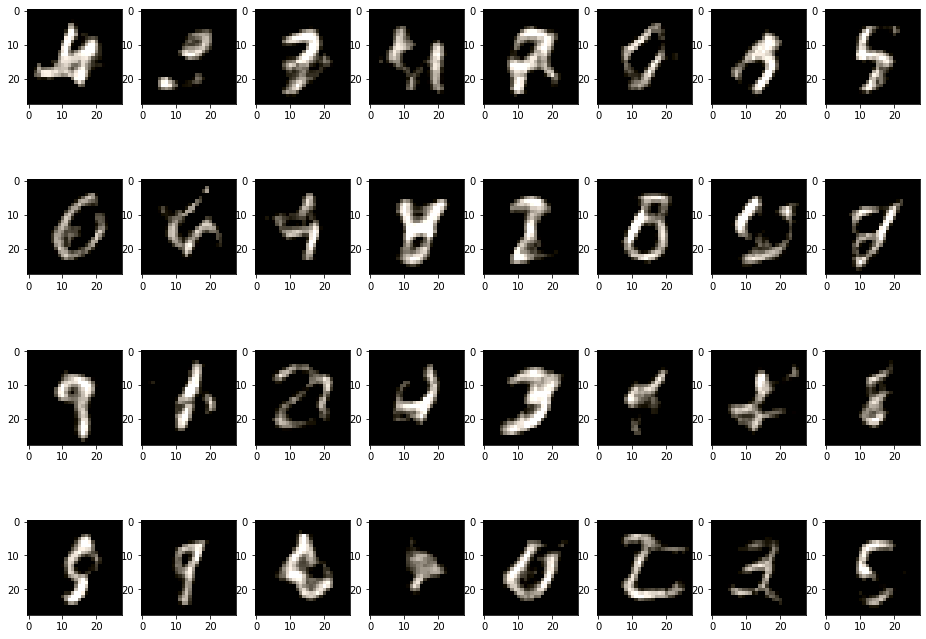

In [50]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
autoencoder.eval()

z = autoencoder.gaussian_sampler(torch.tensor(np.random.normal(0, 1, (32, 128))), torch.tensor(np.random.normal(0, 1, (32, 128))))
output = autoencoder.decoder(z.to(device).float())
output = output.cpu()
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), output):
  imshow(d.data.cpu(), plt_ax=ax)

## 2.2. Latent Representation

# Задание 4

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [51]:
from sklearn.manifold import TSNE

autoencoder.eval()
points = []
labels = []

for X_batch, y_batch in train_loader:
  mu, logsigma = autoencoder.encode(X_batch.to(device))
  z = autoencoder.gaussian_sampler(mu, logsigma)
  for point, label in zip(z.cpu().detach().numpy(), y_batch):
    points.append(point)
    labels.append(label)

In [ ]:
tsne = 
tsne_space = 

In [ ]:
colors_dict = {1: 'b',
               2: 'g',
               3: 'r',
               4: 'c',
               5: 'm',
               6: 'y',
               7: 'k',
               8: '#A020F0',
               9: 'c',
               0: '#FFFF00'}
colors = [colors_dict[int(color)] for color in labels]

In [ ]:
plt.figure(figsize=(16, 14))
plt.scatter(tsne_space[:, 0], tsne_space[:, 1], c=colors);

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE


# Задание 5
Создайте и обучите архитектуру условного автокодировщика.

Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
features = 

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
          
        )

        self.decoder = nn.Sequential(
         
        )

    def encode(self, x, class_num):
        
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):

        return torch.sigmoid(reconstruction)

    def forward(self, x, class_num):
        mu, logsigma, class_num = 
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = 
        return mu, logsigma, reconstruction

In [ ]:
def train_cvae(model, opt, loss_fn, epochs, data_tr, data_val):
    history = {"train_loss": [],
               "val_loss": []}

    best_loss = float("inf")

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device).float()
            y_batch = F.one_hot(y_batch, num_classes=10).to(device).float()
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            mu, logsigma, reconstructed = model(X_batch.float(), y_batch)
            loss = loss_fn(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        history["train_loss"].append(avg_loss.cpu().detach().numpy())

        # show intermediate results
        model.eval()  # testing mode
        
        avg_val_loss = 0
        for X_val_batch, y_val_batch in data_val:
          mu_val, logsigma_val, reconstructed_val_batch = model(X_val_batch.to(device), F.one_hot(y_val_batch, num_classes=10).to(device))
          reconstructed_val_batch = reconstructed_val_batch.detach().cpu()
          mu_val = mu_val.detach().cpu()
          logsigma_val = logsigma_val.detach().cpu()
          avg_val_loss += loss_fn(X_val_batch, mu_val, logsigma_val, reconstructed_val_batch).detach().numpy() / len(data_val)
        
        history["val_loss"].append(avg_val_loss)
        
        if avg_val_loss < best_loss:
          best_loss = avg_val_loss
          torch.save(model.state_dict(), "model.pt")

        # Visualize tools
        plt.figure(figsize=(12, 8))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_batch[k].permute(1, 2, 0).squeeze(), cmap="gray")
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructed_val_batch[k].permute(1, 2, 0).squeeze(), cmap="gray")
            plt.title('Reconstruction')
            plt.axis('off')
        plt.suptitle('%d / %d - train_loss: %f, val_loss: %f' % (epoch+1, epochs, avg_loss, avg_val_loss))
        plt.show()
    # load best model
    model.load_state_dict(torch.load("model.pt"))
    return history

In [ ]:
autoencoder = CVAE()

In [ ]:
criterion = 

autoencoder = 

optimizer = 

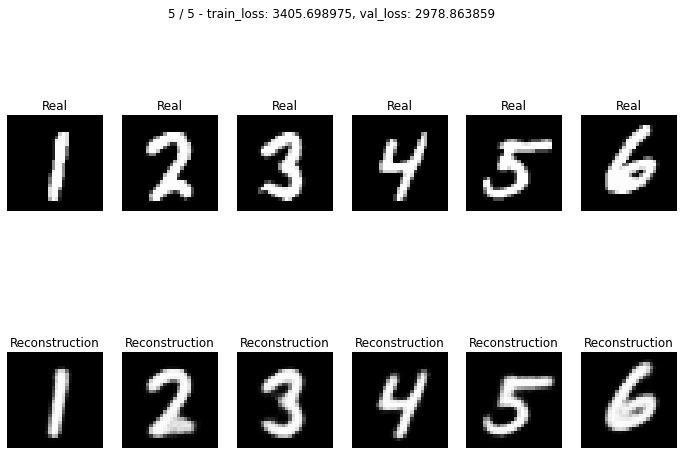

In [ ]:
history_cvae = train_cvae(autoencoder, optimizer, criterion, 5, train_loader, test_loader)

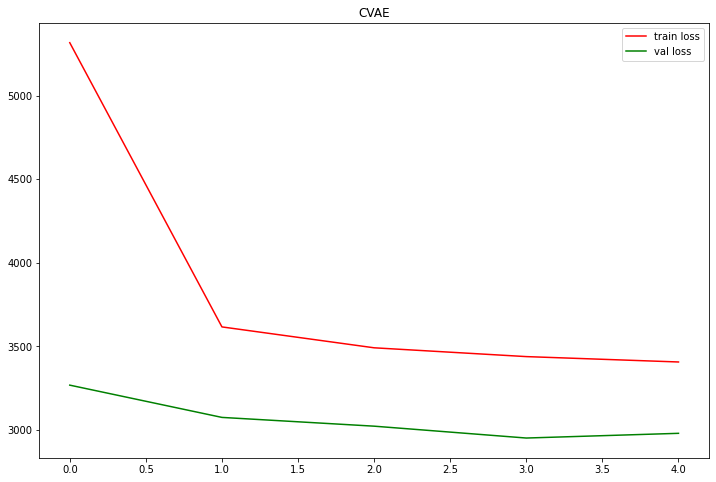

In [ ]:
plot_history(history_cvae, "CVAE")

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.reshape(inp, (28, 28))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp, cmap="binary")
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Фиксируем один вектор и прибавляем к нему вектор каждого из классов

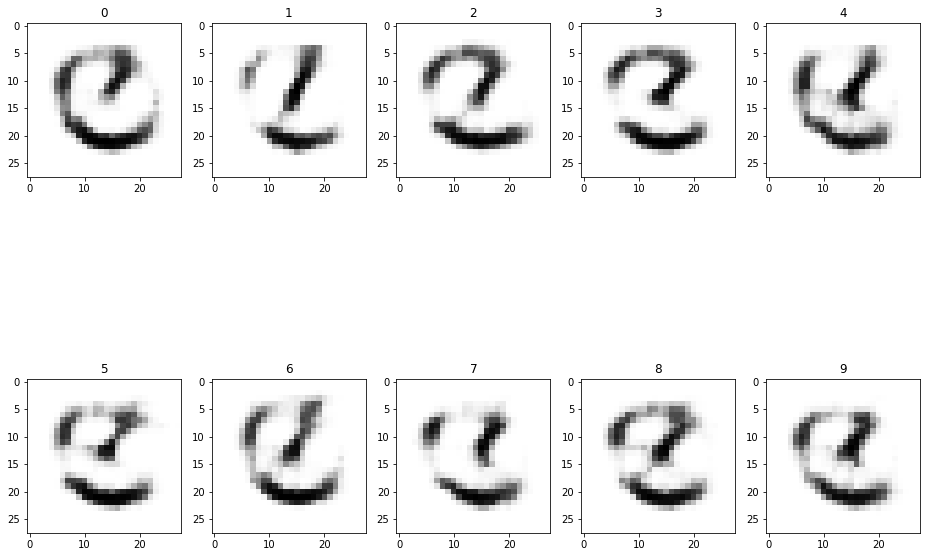

In [ ]:
autoencoder.eval()
one_hot = []
z_s = []

z = autoencoder.gaussian_sampler(torch.tensor(np.random.normal(0, 1, 128)), torch.tensor(np.random.normal(0, 1, 128))).numpy()

for i in range(10):
  one_hot.append(i)
  z_s.append(z)


one_hot = F.one_hot(torch.tensor(one_hot), num_classes=10)
z_s = torch.tensor(z_s)
output = autoencoder.decode(z_s.to(device).float(), one_hot.to(device)).cpu()

axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 12))[1]
counter = 0

for ax, d in zip(axes.flatten(), output):
  imshow(d.data.cpu(), plt_ax=ax, title=counter)
  counter += 1

Теперь из рандомных векторов пытаемся получить число которое будет введено пользователем

Введите какой класс вы хотите получить:1


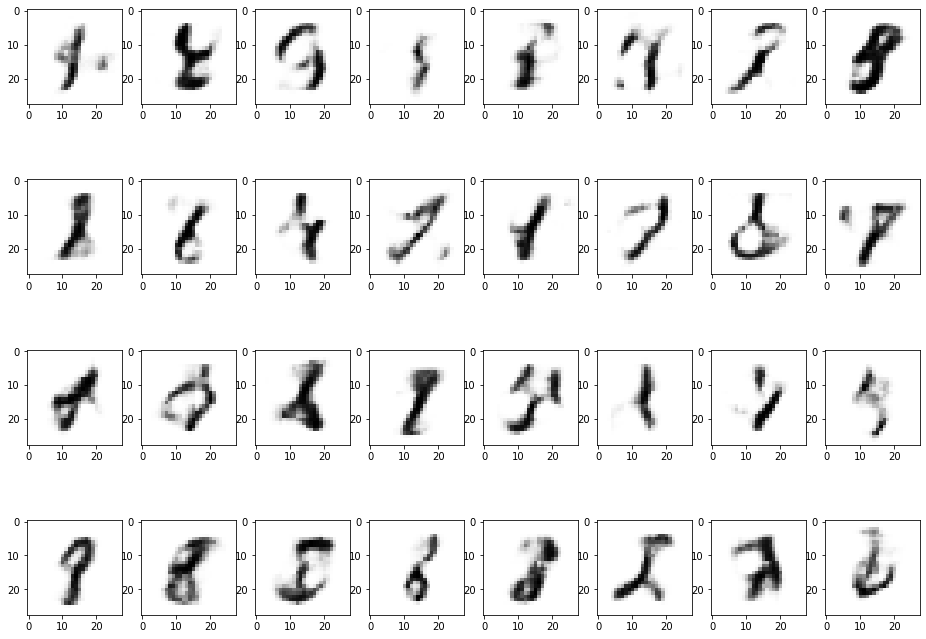

In [ ]:
autoencoder.eval()
numb = int(input("Введите какой класс вы хотите получить:"))

z = autoencoder.gaussian_sampler(torch.tensor(np.random.normal(0, 1, (32, 128))), torch.tensor(np.random.normal(0, 1, (32, 128))))
output = autoencoder.decode(z.to(device).float(), F.one_hot(torch.tensor([numb for _ in range(32)]), num_classes=10).to(device))
output = output.cpu()
axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))[1]

for ax, d in zip(axes.flatten(), output):
  imshow(d.data.cpu(), plt_ax=ax)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
from sklearn.manifold import TSNE

autoencoder.eval()
points = []
labels = []

for X_batch, y_batch in train_loader:
  mu, logsigma, class_num = autoencoder.encode(X_batch.to(device), F.one_hot(y_batch, num_classes=10).to(device))
  z = autoencoder.gaussian_sampler(mu, logsigma)
  z_c = torch.cat([z, class_num], 1)
  for point, label in zip(z_c.cpu().detach().numpy(), y_batch):
    points.append(point)
    labels.append(label)

In [ ]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_space = tsne.fit_transform(points)

In [ ]:
colors_dict = {1: 'b',
               2: 'g',
               3: 'r',
               4: 'c',
               5: 'm',
               6: 'y',
               7: 'k',
               8: '#A020F0',
               9: 'c',
               0: '#FFFF00'}
colors = [colors_dict[int(color)] for color in labels]

In [ ]:
plt.figure(figsize=(16, 14))
plt.scatter(tsne_space[:, 0], tsne_space[:, 1], c=colors);